In [1]:
!pip install pylibjpeg[all]

     ---------------------------------------- 1.7/1.7 MB 15.5 MB/s eta 0:00:00
     ------------------------------------- 565.4/565.4 kB 17.9 MB/s eta 0:00:00
     ---------------------------------------- 138.2/138.2 kB ? eta 0:00:00


In [2]:
!pip install pydicom

     ---------------------------------------- 2.0/2.0 MB 10.4 MB/s eta 0:00:00


In [6]:
import numpy as np
import pandas as pd
import cv2
import pydicom as dc
import matplotlib.pyplot as plt
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut

In [4]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = dc.read_file(path)
    data = dicom.pixel_array
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

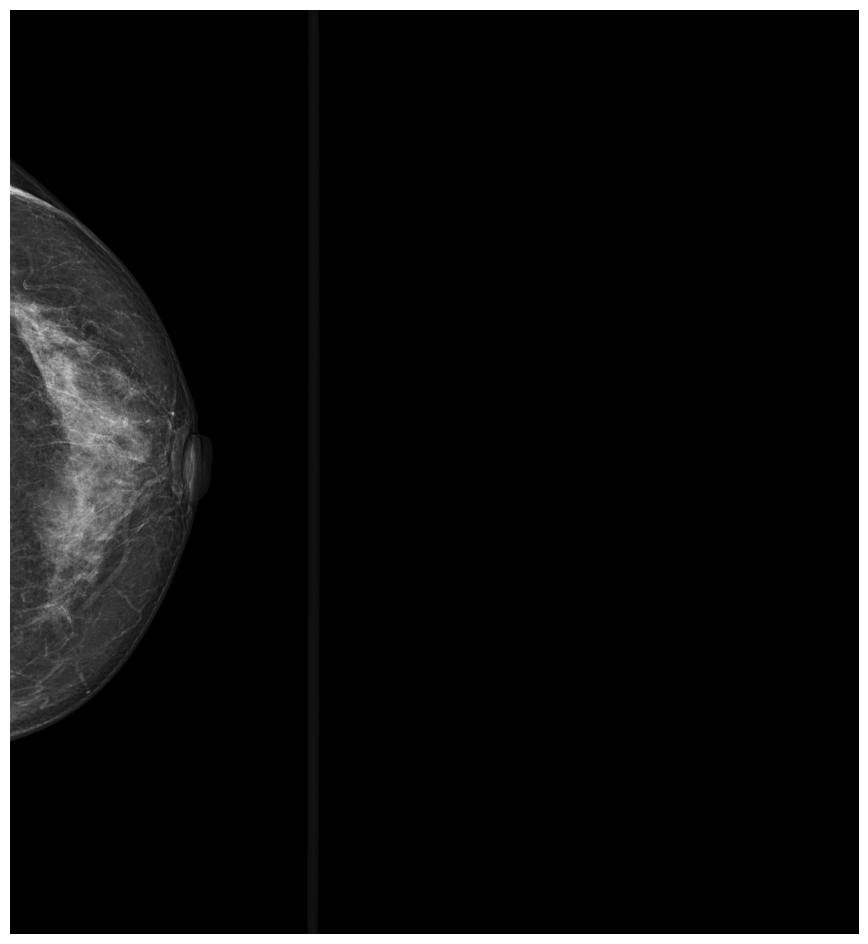

In [5]:
img = read_xray('./train_images/10006/462822612.dcm')

plt.figure(figsize = (12,12))
plt.axis('off')

plt.imshow(img, cmap='gray')

In [8]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [9]:
train.head(10)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
5,2,10011,270344397,L,MLO,55.0,0,0,0,0.0,0,NaN,21,True
6,2,10011,541722628,R,CC,55.0,0,0,0,NaN,0,NaN,21,False
7,2,10011,1031443799,R,MLO,55.0,0,0,0,NaN,0,NaN,21,False
8,2,10025,562340703,L,CC,75.0,0,0,0,NaN,0,NaN,29,False
9,2,10025,1365269360,L,MLO,75.0,0,0,0,NaN,0,NaN,29,False


In [12]:
test

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [22]:
train.loc[train.patient_id==10006]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False


In [26]:
from glob import glob

In [104]:
TRAIN_PATH = './train_images/10006/'
TEST_PATH = './test_images/'

tr_images = glob(f'{TRAIN_PATH}*.dcm')
te_images = glob(f'{TEST_PATH}*.dcm')
tr_images

['./train_images/10006\\1459541791.dcm',
 './train_images/10006\\1864590858.dcm',
 './train_images/10006\\1874946579.dcm',
 './train_images/10006\\462822612.dcm']

In [165]:
def rescale_img_to_hu(dcm_ds):
    """Rescales the image to Hounsfield unit."""
    return dcm_ds.pixel_array# * dcm_ds.RescaleSlope + dcm_ds.RescaleIntercept

def read_dicom_image(image_path):
    x = rescale_img_to_hu(dc.dcmread(image_path))
    x = x - np.min(x)
    x = x / (np.max(x) + 1e-4)
    x = (x * 255).astype(np.uint8)
    return x

def crop_out_image(img):
    av = np.mean(img, axis=0)
    mi = np.min(img, axis=0)
    ma = np.max(img, axis=0)
    img = img[:, (((av - mi) > 2) + ((av - ma) > 2))]
    return img

In [171]:
from PIL import Image

In [191]:
def read_crop_save(patient_id, image_id):
    img = read_dicom_image(os.path.join('./train_images', f"{patient_id}/{image_id}.dcm"))
    img = crop_out_image(img)
    Image.fromarray(img).resize((1024, 1024)).save(f"train_images/{patient_id}/{image_id}.png")

In [184]:
for image_id in list(map(int, [tr_image.split('\\')[1].split('.')[0] for tr_image in tr_images])):
    read_crop_save(10006, image_id)

In [185]:
def crop_coords(img):
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, breast_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    return (x, y, w, h)


def truncation_normalization(img):
    Pmin = np.percentile(img[img!=0], 5)
    Pmax = np.percentile(img[img!=0], 99)
    truncated = np.clip(img,Pmin, Pmax)  
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[img==0]=0
    return normalized


def clahe(img, clip):
    clahe = cv2.createCLAHE(clipLimit=clip)
    cl = clahe.apply(np.array(img*255, dtype=np.uint8))
    return cl

In [186]:
tr_images_png = glob(f'{TRAIN_PATH}*.png')

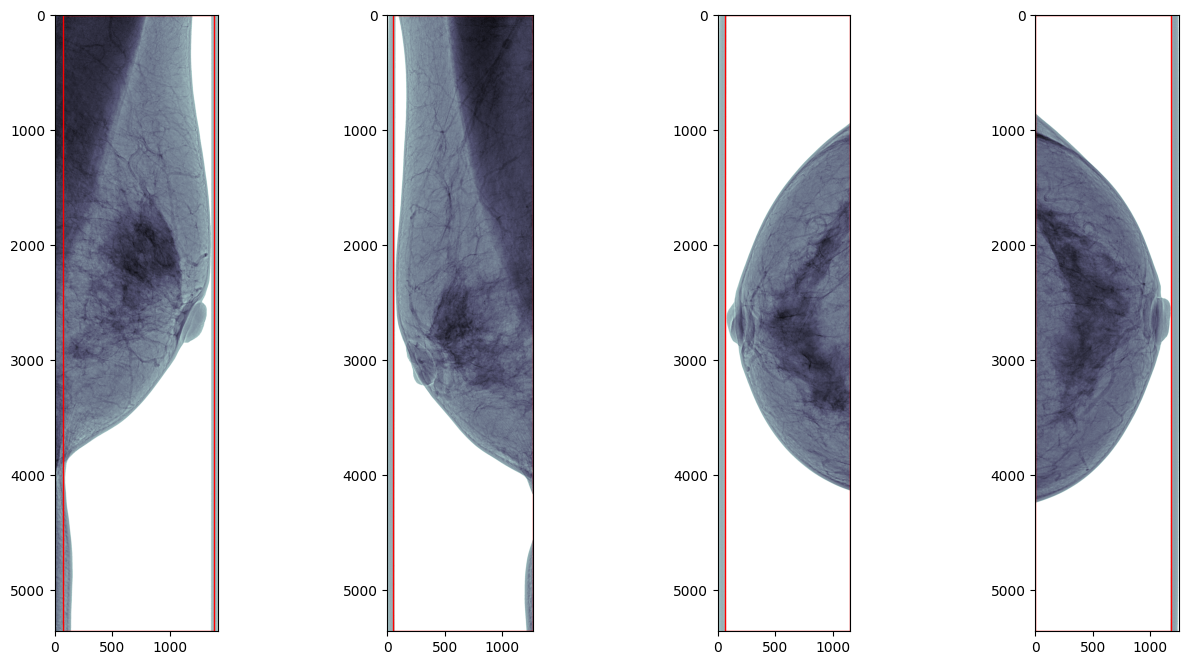

In [187]:
import matplotlib.patches as patches
_, axs = plt.subplots(1, 4, figsize=(16, 8))
axs = axs.flatten()
images = []
for img_path, ax in zip(tr_images_png[:4], axs):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    (x, y, w, h) = crop_coords(img)
    
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    
    ax.add_patch(rect)
    img_cropped = img[y:y+h, x:x+w]
    images.append(img_cropped)
    ax.imshow(img, cmap="bone")

plt.show()

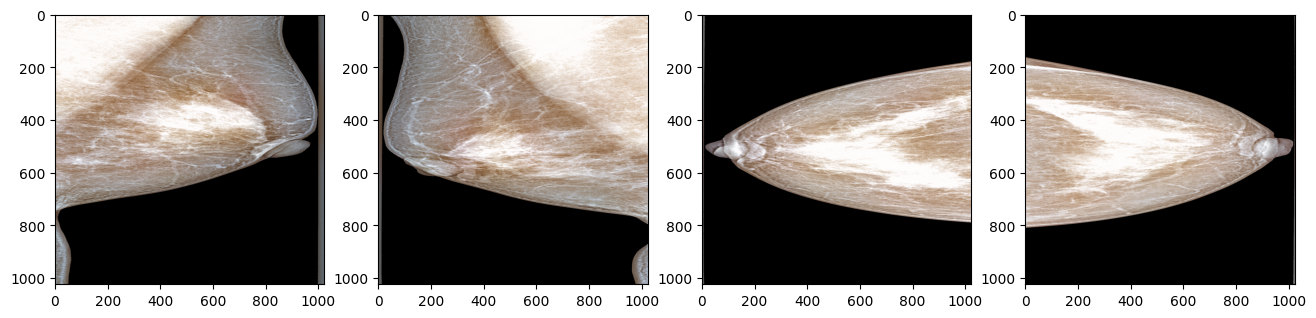

In [193]:
_, axs = plt.subplots(1, 4, figsize=(16, 8))
axs = axs.flatten()
final_imgs = []

# 이미지 크기 설정
IMG_SIZE = 1024


for img_cropped, ax in zip(images, axs):
    img_normalized = truncation_normalization(img_cropped)
    cl1 = clahe(img_normalized, 1.0)
    cl2 = clahe(img_normalized, 2.0)
    img_final = cv2.merge((np.array(img_normalized*255, dtype=np.uint8),cl1,cl2))

    # 이미지 반전 
    img_final = img_final.max() - img_final


    img_final = cv2.resize(img_final, (IMG_SIZE, IMG_SIZE))
    ax.imshow(img_final)
    
plt.show()

In [205]:
train.loc[(train.difficult_negative_case==True) & (train.cancer==0)]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
5,2,10011,270344397,L,MLO,55.0,0,0,0,0.0,0,NaN,21,True
28,1,10049,94335194,R,MLO,52.0,0,0,0,0.0,0,C,49,True
29,1,10049,1207499426,R,MLO,52.0,0,0,0,0.0,0,C,49,True
30,1,10049,1351270472,R,CC,52.0,0,0,0,0.0,0,C,49,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54672,2,9953,1640274067,R,MLO,60.0,0,0,0,0.0,0,NaN,48,True
54673,2,9954,21064441,L,MLO,48.0,0,0,0,0.0,0,NaN,48,True
54674,2,9954,2043422318,L,CC,48.0,0,0,0,0.0,0,NaN,48,True
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [200]:
train.loc[(train.difficult_negative_case==True) & (train.cancer==1)]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case


In [202]:
train.loc[(train.difficult_negative_case==False) & (train.cancer==0)]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
6,2,10011,541722628,R,CC,55.0,0,0,0,NaN,0,NaN,21,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54699,1,9973,1703611570,L,MLO,43.0,0,0,0,1.0,0,C,49,False
54700,1,9973,655941939,R,CC,43.0,0,0,0,1.0,0,C,49,False
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False


In [203]:
train.loc[(train.difficult_negative_case==False) & (train.cancer==1)]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
87,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False
88,1,10130,613462606,L,CC,71.0,1,1,1,0.0,0,B,49,False
89,1,10130,1360338805,L,CC,71.0,1,1,1,0.0,0,B,49,False
90,1,10130,1672636630,L,MLO,71.0,1,1,1,0.0,0,B,49,False
190,1,10226,461614796,L,MLO,71.0,1,1,1,0.0,0,C,49,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54485,2,9707,1900919592,R,MLO,56.0,1,1,1,NaN,0,NaN,21,False
54593,2,9840,111786935,R,MLO,59.0,1,1,1,NaN,0,NaN,21,False
54594,2,9840,1559360810,R,CC,59.0,1,1,1,NaN,0,NaN,21,False
54595,2,9851,1409270544,L,MLO,58.0,1,1,0,NaN,0,NaN,48,False


In [194]:
test

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R
